In [9]:
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
#load_data
df = pd.read_csv('/content/drive/MyDrive/Dataset/jena_climate/jena_climate_2009_2016.csv')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420446,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420447,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420448,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420449,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


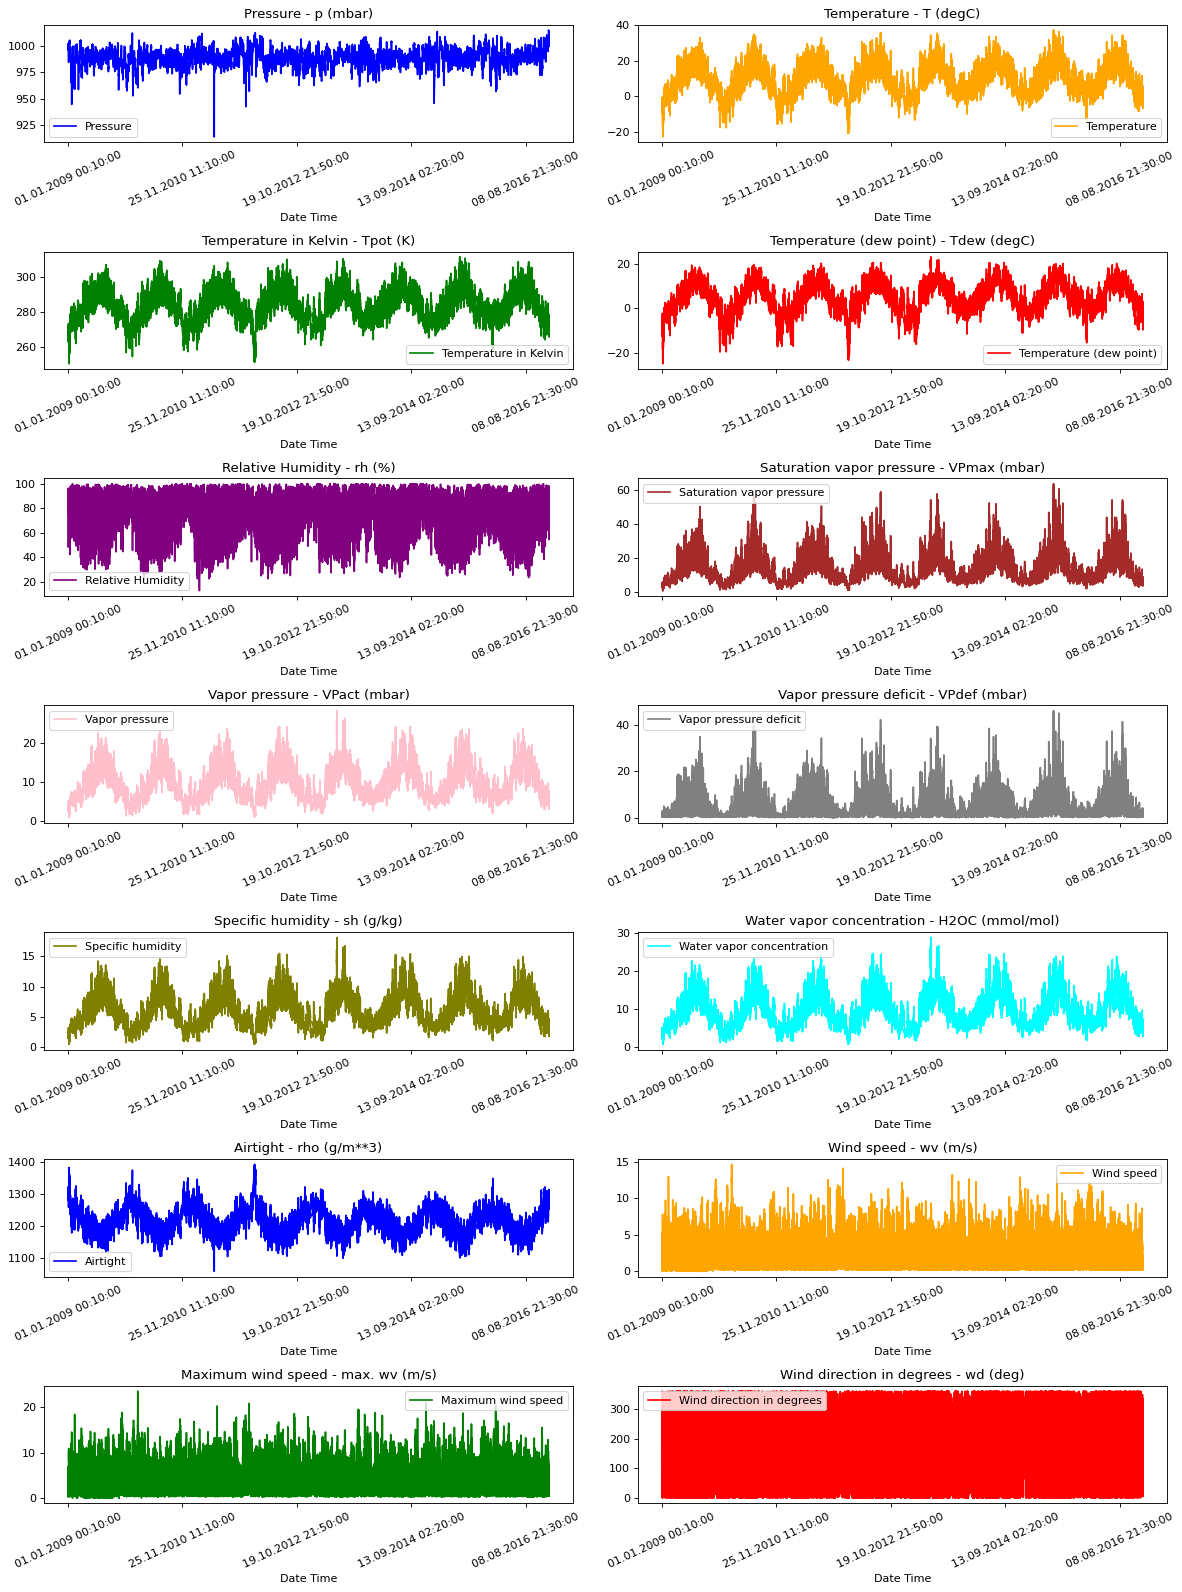

In [ ]:
# data visualization
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

## Data preprocessing

In [3]:
df = df.iloc[:,1:].astype(float)
float_data = df.values

In [4]:
#Normalizing the data
mean = float_data[:200000].mean(axis=0) #200000 시간까지 train으로 사용
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

##non-machine learning baseline
mae = 4.85

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.6218035335644644


In [ ]:
celsius_mae = 0.29 * std[1]

In [ ]:
celsius_mae

4.850921790645354

##machine learning approach

In [ ]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.0799 - val_loss: 0.5552
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3543 - val_loss: 0.3151
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2762 - val_loss: 0.3221
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2591 - val_loss: 0.3098
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2461 - val_loss: 0.3071
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2411 - val_loss: 0.3134
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2344 - val_loss: 0.3244
Epoch 8/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2293 - val_loss: 0.3179
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2250 - val_loss: 0.3410
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.220

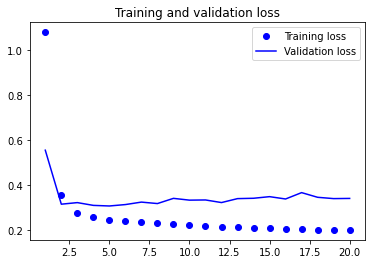

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Using recurrent dropout to fight overfitting

In [ ]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 356s 709ms/step - loss: 0.3229 - val_loss: 0.2802
Epoch 2/40
500/500 [==============================] - 354s 709ms/step - loss: 0.3046 - val_loss: 0.2772
Epoch 3/40
500/500 [==============================] - 354s 708ms/step - loss: 0.2986 - val_loss: 0.2757
Epoch 4/40
500/500 [==============================] - 351s 701ms/step - loss: 0.2934 - val_loss: 0.2729
Epoch 5/40
500/500 [==============================] - 352s 703ms/step - loss: 0.2908 - val_loss: 0.2678
Epoch 6/40
500/500 [==============================] - 350s 700ms/step - loss: 0.2858 - val_loss: 0.2686
Epoch 7/40
500/500 [==============================] - 353s 707ms/step - loss: 0.2823 - val_loss: 0.2680
Epoch 8/40
500/500 [==============================] - 352s 704ms/step - loss: 0.2811 - val_loss: 0.2688
Epoch 9/40
500/500 [==============================] - 352s 704ms/step - loss: 0.2767 - val_loss: 0.2728
Epoch 10/40
500/500 [==============================] - 351s 702ms/step - lo

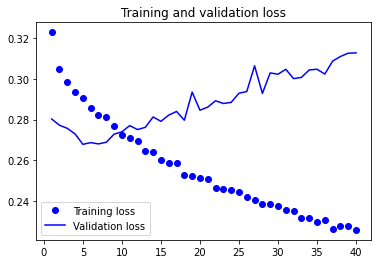

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##Stacking recurrent layers

In [10]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

checkpoint_path = './check.h5'

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_loss',
                                verbose=1)

es = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps, callbacks=[cp, es])

Epoch 1/20
100/100 [==============================] - 220s 2s/step - loss: 0.3473 - val_loss: 0.2901

Epoch 00001: val_loss improved from inf to 0.29011, saving model to ./check.h5
Epoch 2/20
100/100 [==============================] - 216s 2s/step - loss: 0.3186 - val_loss: 0.3019

Epoch 00002: val_loss did not improve from 0.29011
Epoch 3/20
100/100 [==============================] - 216s 2s/step - loss: 0.3156 - val_loss: 0.2850

Epoch 00003: val_loss improved from 0.29011 to 0.28500, saving model to ./check.h5
Epoch 4/20
100/100 [==============================] - 215s 2s/step - loss: 0.3044 - val_loss: 0.2801

Epoch 00004: val_loss improved from 0.28500 to 0.28006, saving model to ./check.h5
Epoch 5/20
100/100 [==============================] - 217s 2s/step - loss: 0.3093 - val_loss: 0.2805

Epoch 00005: val_loss did not improve from 0.28006
Epoch 6/20
100/100 [==============================] - 216s 2s/step - loss: 0.3100 - val_loss: 0.2782

Epoch 00006: val_loss improved from 0.280

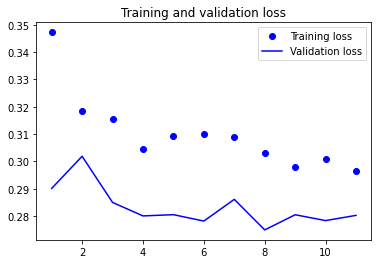

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##Stacking recurrent layers 

In [13]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

cp = ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_loss',
                                verbose=1)

es = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_gen,
                              steps_per_epoch=100,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps, callbacks=[cp, es])

Epoch 1/40
100/100 [==============================] - 221s 2s/step - loss: 0.3542 - val_loss: 0.3000

Epoch 00001: val_loss improved from inf to 0.30003, saving model to ./check.h5
Epoch 2/40
100/100 [==============================] - 217s 2s/step - loss: 0.3186 - val_loss: 0.2832

Epoch 00002: val_loss improved from 0.30003 to 0.28316, saving model to ./check.h5
Epoch 3/40
100/100 [==============================] - 218s 2s/step - loss: 0.3136 - val_loss: 0.3074

Epoch 00003: val_loss did not improve from 0.28316
Epoch 4/40
100/100 [==============================] - 216s 2s/step - loss: 0.3096 - val_loss: 0.2938

Epoch 00004: val_loss did not improve from 0.28316
Epoch 5/40
100/100 [==============================] - 216s 2s/step - loss: 0.3074 - val_loss: 0.2781

Epoch 00005: val_loss improved from 0.28316 to 0.27815, saving model to ./check.h5
Epoch 6/40
100/100 [==============================] - 216s 2s/step - loss: 0.3064 - val_loss: 0.2794

Epoch 00006: val_loss did not improve fro

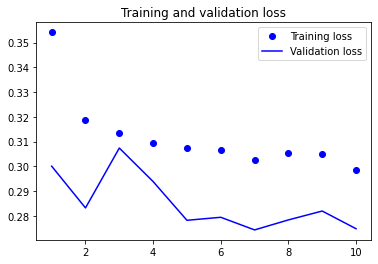

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()